## Imports

In [501]:
import os
import random
import inspect

import numpy as np
import pandas as pd
from shapflow.flow import GraphExplainer, CausalLinks, build_feature_graph

from autograd import Value, populate_dataframe, build_causal_graph, draw_computational_graph

## Constants

**Message from Arijit:**

Common adsorbent for all: SIV

CH4 & 323K: JRY

CH4 & 373K: NPT

CO2 & 323K: STI

CO2 & 373K: RWR

N2 & 323K: GON

N2 & 373K: MFS

In [502]:
# TODO N2 at 373K is overflowing
TEMPERATURE = 373 # Can be either 323 or 373
PRESSURE_IDX = 7 # Setting to 0 will index the minimum pressure value
ADSORBATE = 'N2'
BACKGROUND_ADSORBENT = 'MFS'
FOREGROUND_ADSORBENT = 'SIV'

In [503]:
CATALYSTS_LOC_STR = "data/zeolite/complete_data_avail.xlsx"
_zeoliteS_DATA = pd.read_excel(zeoliteS_LOC_STR)
ADSORBATE_LOC_STR = f"data/zeolite/{ADSORBATE}.xlsx"
ADSORBATE_DATA: dict = pd.read_excel(ADSORBATE_LOC_STR, sheet_name=None)
RESULTS_FILE_PATH = f'data/zeolite/{ADSORBATE}_RESULTS_{str(TEMPERATURE)}.npy'

In [505]:
with open(RESULTS_FILE_PATH, 'rb') as RESULTS_FILE:
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)

In [506]:
P_TRAIN_STD

array(1840475.75120773)

## Equations

TODO List:
1. Confirm that the equations are correct

### CH4 Equations

In [507]:
def predict_CH4_323K(
        P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
        SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
        SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
        largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
    ):
    Value.reset()

    # input variables
    P = Value(P, label='P')
    density = Value(density, label='density')
    spg = Value(spg, label='spg')
    volume = Value(volume, label='volume')
    SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
    SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
    SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
    SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
    SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
    SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
    SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
    SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
    SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
    SiO_average = Value(SiO_average, label='SiO_average')
    SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
    SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
    SiO_max = Value(SiO_max, label='SiO_max')
    SiO_mean = Value(SiO_mean, label='SiO_mean')
    SiO_min = Value(SiO_min, label='SiO_min')
    SiO_skew = Value(SiO_skew, label='SiO_skew')
    SiO_std = Value(SiO_std, label='SiO_std')
    SiO_var = Value(SiO_var, label='SiO_var')
    ASA = Value(ASA, label='ASA')
    AV = Value(AV, label='AV')
    NASA = Value(NASA, label='NASA')
    NAV = Value(NAV, label='NAV')
    VolFrac = Value(VolFrac, label='VolFrac')
    largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
    largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
    largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
    max_dim = Value(max_dim, label='max_dim')
    min_dim = Value(min_dim, label='min_dim')
    mode_dim = Value(mode_dim, label='mode_dim')
    pld = Value(pld, label='pld')
    lcd = Value(lcd, label='lcd')
    void_frac = Value(void_frac, label='void_frac')
    surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
    surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

    # constants
    beta1 = Value(-0.4054507842872319, label='beta1')
    beta2 = Value(-3.5824569383000946, label='beta2')
    beta3 = Value(3.9932667095050705, label='beta3')
    beta4 = Value(0.5222507180877926, label='beta4')
    beta5 = Value(0.004795464592376811, label='beta5')
    beta6 = Value(-0.1129628499436825, label='beta6')
    beta7 = Value(0.013835556053187287, label='beta7')
    beta8 = Value(-0.09608874134668977, label='beta8')
    intercept = Value(0.0, label='intercept')

    # f terms
    f1 = ((largest_included_sphere*NAV.exp()*(-surf_area_m2cm3).exp()) * P / 
        (1 + (largest_included_sphere*NAV.exp()*(-surf_area_m2cm3).exp()) * P) - 
        0.07469040214406462)/0.23351307544167757
    f1.label = 'f1'

    f2 = ((VolFrac.exp()/(-AV).exp()) * P / 
        (1 + (VolFrac.exp()/(-AV).exp()) * P) - 
        0.593439038924528)/0.19855903035643785
    f2.label = 'f2'

    f3 = ((void_frac.exp()) * P / 
        (1 + (void_frac.exp()) * P) - 
        0.6258918477237851)/0.19909573031440259
    f3.label = 'f3'

    f4 = ((AV/VolFrac.exp()*void_frac) * P / 
        (1 + (AV/VolFrac.exp()*void_frac) * P) - 
        0.026347531768028034)/0.033050115887121194
    f4.label = 'f4'

    f5 = (((-NASA).exp()*(surf_area_m2cm3**2)*spg) * P / 
        (1 + ((-NASA).exp()*(surf_area_m2cm3**2)*spg) * P) - 
        0.451590663829706)/0.4976497103725683
    f5.label = 'f5'

    f6 = (((surf_area_m2cm3**2)*(-volume).exp()*volume) * P / 
        (1 + ((surf_area_m2cm3**2)*(-volume).exp()*volume) * P) - 
        0.04040880811128878)/0.05992104058313283
    f6.label = 'f6'

    f7 = ((1/surf_area_m2g.exp()/pld) * P / 
        (1 + (1/surf_area_m2g.exp()/pld) * P) - 
        0.033471221601783376)/0.11285951143033723
    f7.label = 'f7'

    f8 = ((VolFrac**2/(-pld).exp()) * P / 
        (1 + (VolFrac**2/(-pld).exp()) * P) - 
        0.3805783317820693)/0.36837799819503636
    f8.label = 'f8'

    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8; theta.label = 'theta'

    loading_at_zero_P = (
        -beta1*0.07469040214406462/0.233513075441677571 +
        -beta2*0.593439038924528/0.198559030356437852 + 
        -beta3*0.6258918477237851/0.199095730314402593 + 
        -beta4*0.026347531768028034/0.0330501158871211944 + 
        -beta5*0.451590663829706/0.49764971037256835 + 
        -beta6*0.04040880811128878/0.059921040583132836 + 
        -beta7*0.033471221601783376/0.112859511430337237 + 
        -beta8*0.3805783317820693/0.368377998195036368
    ); loading_at_zero_P.label = 'loading_at_zero_P'

    epsilon_max = Value(1.0, label='epsilon_max')
    d = (P - 0.0).abs(); d.label = 'd'
    alpha = Value(2.0, label='alpha')
    y_train_mean = Value(np.mean(y_train), label='y_train_mean')

    y = theta + intercept + y_train_mean + (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
    y.label = 'y'

    return y

In [508]:
def predict_CH4_373K(
          P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
          SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
          SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
          largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
      ):
      Value.reset()

      # input variables
      P = Value(P, label='P')
      density = Value(density, label='density')
      spg = Value(spg, label='spg')
      volume = Value(volume, label='volume')
      SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
      SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
      SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
      SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
      SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
      SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
      SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
      SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
      SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
      SiO_average = Value(SiO_average, label='SiO_average')
      SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
      SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
      SiO_max = Value(SiO_max, label='SiO_max')
      SiO_mean = Value(SiO_mean, label='SiO_mean')
      SiO_min = Value(SiO_min, label='SiO_min')
      SiO_skew = Value(SiO_skew, label='SiO_skew')
      SiO_std = Value(SiO_std, label='SiO_std')
      SiO_var = Value(SiO_var, label='SiO_var')
      ASA = Value(ASA, label='ASA')
      AV = Value(AV, label='AV')
      NASA = Value(NASA, label='NASA')
      NAV = Value(NAV, label='NAV')
      VolFrac = Value(VolFrac, label='VolFrac')
      largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
      largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
      largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
      max_dim = Value(max_dim, label='max_dim')
      min_dim = Value(min_dim, label='min_dim')
      mode_dim = Value(mode_dim, label='mode_dim')
      pld = Value(pld, label='pld')
      lcd = Value(lcd, label='lcd')
      void_frac = Value(void_frac, label='void_frac')
      surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
      surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

      # Constants
      beta1 = Value(0.1909906610367201, label='beta1')
      beta2 = Value(0.11682964613884445, label='beta2')
      beta3 = Value(-0.09344427307559947, label='beta3')
      beta4 = Value(0.20074867148999848, label='beta4')
      beta5 = Value(0.11122063059032497, label='beta5')
      beta6 = Value(0.5214533740342101, label='beta6')
      beta7 = Value(-0.3427553886500203, label='beta7')
      beta8 = Value(-0.21426185160030492, label='beta8')
      intercept = Value(0.0, label='intercept')

      # f terms
      f1 = ((1/1*1) * P / 
            (1 + (1/1*1) * P) - 
            0.5657765094736966)/0.1957614458698153
      f1.label = 'f1'

      f2 = (((-largest_included_sphere_free).exp()/1*surf_area_m2cm3) * P / 
            (1 + ((-largest_included_sphere_free).exp()/1*surf_area_m2cm3) * P) - 
            0.4894973861635249)/0.30511699644959617
      f2.label = 'f2'

      f3 = ((NAV.exp()/spg*1) * P / 
            (1 + (NAV.exp()/spg*1) * P) - 
            0.054277814589412984)/0.09756094243688461
      f3.label = 'f3'

      f4 = ((density.exp()/1*(VolFrac**2)) * P / 
            (1 + (density.exp()/1*(VolFrac**2)) * P) - 
            0.07338101892284041)/0.08803243033873245
      f4.label = 'f4'

      f5 = ((largest_included_sphere_free.exp()/(spg**2)/largest_free_sphere.exp()) * P / 
            (1 + (largest_included_sphere_free.exp()/(spg**2)/largest_free_sphere.exp()) * P) - 
            0.04457244307054062)/0.14950551357237374
      f5.label = 'f5'

      f6 = ((void_frac**2/1/1) * P / 
            (1 + (void_frac**2/1/1) * P) - 
            0.13314539459770083)/0.09567259821436203
      f6.label = 'f6'

      f7 = ((VolFrac**2/1/void_frac**2) * P / 
            (1 + (VolFrac**2/1/void_frac**2) * P) - 
            0.11368892880920235)/0.1094460306216634
      f7.label = 'f7'

      f8 = (((-surf_area_m2g).exp()*1*1) * P / 
            (1 + ((-surf_area_m2g).exp()*1*1) * P) - 
            0.0539764858809039)/0.17390362993878106
      f8.label = 'f8'

      theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8; theta.label = 'theta'

      loading_at_zero_P = (
            -beta1*0.5657765094736966/0.19576144586981531 +
            -beta2*0.4894973861635249/0.305116996449596172 + 
            -beta3*0.054277814589412984/0.097560942436884613 + 
            -beta4*0.07338101892284041/0.088032430338732454 + 
            -beta5*0.04457244307054062/0.149505513572373745 + 
            -beta6*0.13314539459770083/0.095672598214362036 + 
            -beta7*0.11368892880920235/0.10944603062166347 + 
            -beta8*0.0539764858809039/0.173903629938781068
      ); loading_at_zero_P.label = 'loading_at_zero_P'

      epsilon_max = Value(1.0, label='epsilon_max')
      d = (P - 0.0).abs(); d.label = 'd'
      alpha = Value(2.0, label='alpha')
      y_train_mean = Value(np.mean(y_train), label='y_train_mean')

      y = theta + intercept + y_train_mean - (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
      y.label = 'y'

      return y

### CO2 Equations

In [509]:
def predict_CO2_323K(
          P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
          SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
          SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
          largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
      ):
      Value.reset()

      # input variables
      P = Value(P, label='P')
      density = Value(density, label='density')
      spg = Value(spg, label='spg')
      volume = Value(volume, label='volume')
      SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
      SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
      SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
      SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
      SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
      SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
      SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
      SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
      SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
      SiO_average = Value(SiO_average, label='SiO_average')
      SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
      SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
      SiO_max = Value(SiO_max, label='SiO_max')
      SiO_mean = Value(SiO_mean, label='SiO_mean')
      SiO_min = Value(SiO_min, label='SiO_min')
      SiO_skew = Value(SiO_skew, label='SiO_skew')
      SiO_std = Value(SiO_std, label='SiO_std')
      SiO_var = Value(SiO_var, label='SiO_var')
      ASA = Value(ASA, label='ASA')
      AV = Value(AV, label='AV')
      NASA = Value(NASA, label='NASA')
      NAV = Value(NAV, label='NAV')
      VolFrac = Value(VolFrac, label='VolFrac')
      largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
      largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
      largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
      max_dim = Value(max_dim, label='max_dim')
      min_dim = Value(min_dim, label='min_dim')
      mode_dim = Value(mode_dim, label='mode_dim')
      pld = Value(pld, label='pld')
      lcd = Value(lcd, label='lcd')
      void_frac = Value(void_frac, label='void_frac')
      surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
      surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

      # Constants
      beta1 = Value(0.2408158535926262, label='beta1')
      beta2 = Value(-0.6051468741071055, label='beta2')
      beta3 = Value(0.17771546567926963, label='beta3')
      beta4 = Value(-2.0804716603104425, label='beta4')
      beta5 = Value(-0.35101203615301246, label='beta5')
      beta6 = Value(1.1201332339583743, label='beta6')
      beta7 = Value(0.0023376143648303396, label='beta7')
      beta8 = Value(-0.12134179550190091, label='beta8')
      beta9 = Value(-1.215940666467515, label='beta9')
      beta10 = Value(2.3657034591203896, label='beta10')
      beta11 = Value(-0.6619785317203183, label='beta11')
      beta12 = Value(1.712890108697996, label='beta12')
      intercept = Value(0.0, label='intercept')

      # f terms
      f1 = ((NASA*volume/1) * P / 
            (1 + (NASA*volume/1) * P) - 
            0.5053560148639079)/0.4960635647959033
      f1.label = 'f1'

      f2 = ((NAV/largest_free_sphere.exp()*(largest_included_sphere**2)) * P / 
            (1 + (NAV/largest_free_sphere.exp()*(largest_included_sphere**2)) * P) - 
            0.022023073277147264)/0.07412726445549916
      f2.label = 'f2'

      f3 = ((spg.exp()*(-NASA).exp()/AV.exp()) * P / 
            (1 + (spg.exp()*(-NASA).exp()/AV.exp()) * P) - 
            0.636492475959887)/0.4788319028018178
      f3.label = 'f3'

      f4 = ((density*VolFrac*1) * P / 
            (1 + (density*VolFrac*1) * P) - 
            0.15658870051279075)/0.13014735733464328
      f4.label = 'f4'

      f5 = ((lcd**2/1/largest_free_sphere.exp()) * P / 
            (1 + (lcd**2/1/largest_free_sphere.exp()) * P) - 
            0.4486063640488222)/0.2755565010621821
      f5.label = 'f5'

      f6 = ((volume/density.exp()/VolFrac.exp()) * P / 
            (1 + (volume/density.exp()/VolFrac.exp()) * P) - 
            0.769527662996705)/0.1914254994515539
      f6.label = 'f6'

      f7 = ((NASA/spg.exp()/1) * P / 
            (1 + (NASA/spg.exp()/1) * P) - 
            0.018544154536591098)/0.1134031399766316
      f7.label = 'f7'

      f8 = ((lcd**2/1/1) * P / 
            (1 + (lcd**2/1/1) * P) - 
            0.9474631921424108)/0.11185899780233935
      f8.label = 'f8'

      f9 = ((pld/volume*1) * P / 
            (1 + (pld/volume*1) * P) - 
            0.2259632424704171)/0.12819776041479525
      f9.label = 'f9'

      f10 = ((void_frac/1/1) * P / 
            (1 + (void_frac/1/1) * P) - 
            0.2983059470851118)/0.15314334975683067
      f10.label = 'f10'

      f11 = ((1*1*1) * P / 
            (1 + (1*1*1) * P) - 
            0.561041654561111)/0.19904288999498684
      f11.label = 'f11'

      f12 = ((VolFrac*1*1) * P / 
            (1 + (VolFrac*1*1) * P) - 
            0.10745167163360558)/0.09939185680979355
      f12.label = 'f12'

      theta = (
            beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8 + beta9*f9 + beta10*f10 + beta11*f11 + beta12*f12
      ); theta.label = 'theta'

      loading_at_zero_P = (
            -beta1*0.5053560148639079/0.49606356479590331 + 
            -beta2*0.022023073277147264/0.074127264455499162 + 
            -beta3*0.636492475959887/0.47883190280181783 + 
            -beta4*0.15658870051279075/0.130147357334643284 + 
            -beta5*0.4486063640488222/0.27555650106218215 + 
            -beta6*0.769527662996705/0.19142549945155396 + 
            -beta7*0.018544154536591098/0.11340313997663167 + 
            -beta8*0.9474631921424108/0.111858997802339358 + 
            -beta9*0.2259632424704171/0.128197760414795259 + 
            -beta10*0.2983059470851118/0.1531433497568306710 + 
            -beta11*0.561041654561111/0.1990428899949868411 + 
            -beta12*0.10745167163360558/0.0993918568097935512
      ); loading_at_zero_P.label = 'loading_at_zero_P'

      epsilon_max = Value(1.0, label='epsilon_max')
      d = (P - 0.0).abs(); d.label = 'd'
      alpha = Value(2.0, label='alpha')
      y_train_mean = Value(np.mean(y_train), label='y_train_mean')

      y = theta + intercept + y_train_mean - (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
      y.label = 'y'

      return y

In [510]:
def predict_CO2_373K(
        P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
        SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
        SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
        largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
    ):
    Value.reset()

    # input variables
    P = Value(P, label='P')
    density = Value(density, label='density')
    spg = Value(spg, label='spg')
    volume = Value(volume, label='volume')
    SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
    SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
    SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
    SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
    SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
    SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
    SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
    SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
    SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
    SiO_average = Value(SiO_average, label='SiO_average')
    SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
    SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
    SiO_max = Value(SiO_max, label='SiO_max')
    SiO_mean = Value(SiO_mean, label='SiO_mean')
    SiO_min = Value(SiO_min, label='SiO_min')
    SiO_skew = Value(SiO_skew, label='SiO_skew')
    SiO_std = Value(SiO_std, label='SiO_std')
    SiO_var = Value(SiO_var, label='SiO_var')
    ASA = Value(ASA, label='ASA')
    AV = Value(AV, label='AV')
    NASA = Value(NASA, label='NASA')
    NAV = Value(NAV, label='NAV')
    VolFrac = Value(VolFrac, label='VolFrac')
    largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
    largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
    largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
    max_dim = Value(max_dim, label='max_dim')
    min_dim = Value(min_dim, label='min_dim')
    mode_dim = Value(mode_dim, label='mode_dim')
    pld = Value(pld, label='pld')
    lcd = Value(lcd, label='lcd')
    void_frac = Value(void_frac, label='void_frac')
    surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
    surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

    # Constants
    beta1 = Value(-0.679081742692596, label='beta1')
    beta2 = Value(0.20307777789750459, label='beta2')
    beta3 = Value(0.4329129291782464, label='beta3')
    beta4 = Value(0.3464949739458949, label='beta4')
    beta5 = Value(0.17098884194225522, label='beta5')
    beta6 = Value(2.2905076502184967, label='beta6')
    beta7 = Value(-0.22028767452266362, label='beta7')
    beta8 = Value(-1.2269155949581563, label='beta8')
    beta9 = Value(-0.8108018121501624, label='beta9')
    beta10 = Value(0.05328000691618266, label='beta10')
    beta11 = Value(-0.19349635098380905, label='beta11')
    beta12 = Value(0.284054306504558, label='beta12')
    intercept = Value(0.0, label='intercept')

    # f terms
    f1 = (((-pld).exp()/1/1) * P / 
          (1 + ((-pld).exp()/1/1) * P) - 
          0.06471130620155797)/0.08312215260703829
    f1.label = 'f1'

    f2 = (((-surf_area_m2g).exp()*1*NASA) * P / 
          (1 + ((-surf_area_m2g).exp()*1*NASA) * P) - 
          0.047511004998993515)/0.20078477954126026
    f2.label = 'f2'

    f3 = (((-largest_included_sphere).exp()*(-NAV).exp()/1) * P / 
          (1 + ((-largest_included_sphere).exp()*(-NAV).exp()/1) * P) - 
          0.011389997203239096)/0.018491549386222977
    f3.label = 'f3'

    f4 = (((-lcd).exp()*(volume**2)*1) * P / 
          (1 + ((-lcd).exp()*(volume**2)*1) * P) - 
          0.5646842961313753)/0.30068050566097687
    f4.label = 'f4'

    f5 = ((void_frac.exp()/density*1) * P / 
          (1 + (void_frac.exp()/density*1) * P) - 
          0.5136090001227659)/0.19590195356823578
    f5.label = 'f5'

    f6 = (((-NAV).exp()*void_frac*1) * P / 
          (1 + ((-NAV).exp()*void_frac*1) * P) - 
          0.3000617637006874)/0.15336443564059765
    f6.label = 'f6'

    f7 = (((-void_frac).exp()/1*1) * P / 
          (1 + ((-void_frac).exp()/1*1) * P) - 
          0.49975562767787235)/0.191365996679738
    f7.label = 'f7'

    f8 = (((density**2)*VolFrac*VolFrac.exp()) * P / 
          (1 + ((density**2)*VolFrac*VolFrac.exp()) * P) - 
          0.24088977178365023)/0.18102771146462537
    f8.label = 'f8'

    f9 = ((largest_free_sphere/1/(largest_included_sphere_free**2)) * P / 
          (1 + (largest_free_sphere/1/(largest_included_sphere_free**2)) * P) - 
          0.16738596411370837)/0.10655406891164021
    f9.label = 'f9'

    f10 = (((NASA**2)/1/NASA.exp()) * P / 
           (1 + ((NASA**2)/1/NASA.exp()) * P) - 
           0.001524646748204257)/0.014373101141606134
    f10.label = 'f10'

    f11 = ((surf_area_m2g*(NAV**2)*1) * P / 
           (1 + (surf_area_m2g*(NAV**2)*1) * P) - 
           0.030270422267265115)/0.1039627226006907
    f11.label = 'f11'

    f12 = ((VolFrac/largest_free_sphere*1) * P / 
           (1 + (VolFrac/largest_free_sphere*1) * P) - 
           0.029136294307661747)/0.027715446590296355
    f12.label = 'f12'

    theta = (beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + 
            beta7*f7 + beta8*f8 + beta9*f9 + beta10*f10 + beta11*f11 + beta12*f12); theta.label = 'theta'

    loading_at_zero_P = (
        -beta1*0.06471130620155797/0.083122152607038291 + 
        -beta2*0.047511004998993515/0.200784779541260262 + 
        -beta3*0.011389997203239096/0.0184915493862229773 + 
        -beta4*0.5646842961313753/0.300680505660976874 + 
        -beta5*0.5136090001227659/0.195901953568235785 + 
        -beta6*0.3000617637006874/0.153364435640597656 + 
        -beta7*0.49975562767787235/0.1913659966797387 + 
        -beta8*0.24088977178365023/0.181027711464625378 + 
        -beta9*0.16738596411370837/0.106554068911640219 + 
        -beta10*0.001524646748204257/0.01437310114160613410 + 
        -beta11*0.030270422267265115/0.103962722600690711 + 
        -beta12*0.029136294307661747/0.02771544659029635512
    ); loading_at_zero_P.label = 'loading_at_zero_P'

    epsilon_max = Value(1.0, label='epsilon_max')
    d = (P - 0.0).abs(); d.label = 'd'
    alpha = Value(2.0, label='alpha')
    y_train_mean = Value(np.mean(y_train), label='y_train_mean')

    y = theta + intercept + y_train_mean - (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
    y.label = 'y'

    return y


### N2 Equations

In [511]:
def predict_N2_323K(
        P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
        SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
        SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
        largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
    ):
    Value.reset()

    # input variables
    P = Value(P, label='P')
    density = Value(density, label='density')
    spg = Value(spg, label='spg')
    volume = Value(volume, label='volume')
    SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
    SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
    SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
    SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
    SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
    SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
    SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
    SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
    SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
    SiO_average = Value(SiO_average, label='SiO_average')
    SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
    SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
    SiO_max = Value(SiO_max, label='SiO_max')
    SiO_mean = Value(SiO_mean, label='SiO_mean')
    SiO_min = Value(SiO_min, label='SiO_min')
    SiO_skew = Value(SiO_skew, label='SiO_skew')
    SiO_std = Value(SiO_std, label='SiO_std')
    SiO_var = Value(SiO_var, label='SiO_var')
    ASA = Value(ASA, label='ASA')
    AV = Value(AV, label='AV')
    NASA = Value(NASA, label='NASA')
    NAV = Value(NAV, label='NAV')
    VolFrac = Value(VolFrac, label='VolFrac')
    largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
    largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
    largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
    max_dim = Value(max_dim, label='max_dim')
    min_dim = Value(min_dim, label='min_dim')
    mode_dim = Value(mode_dim, label='mode_dim')
    pld = Value(pld, label='pld')
    lcd = Value(lcd, label='lcd')
    void_frac = Value(void_frac, label='void_frac')
    surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
    surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

    # Constants
    beta1 = Value(-0.06012649624795871, label='beta1')
    beta2 = Value(0.29171999178744773, label='beta2')
    beta3 = Value(-0.001505369599999802, label='beta3')
    beta4 = Value(0.030830007929509663, label='beta4')
    beta5 = Value(-0.3257118942142511, label='beta5')
    beta6 = Value(0.5292953747226462, label='beta6')
    intercept = Value(0.0, label='intercept')

    # f terms
    f1 = ((pld**2*void_frac/volume**2) * P / 
          (1 + (pld**2*void_frac/volume**2) * P) - 
          0.024842285545539616)/0.029315086987157343
    f1.label = 'f1'

    f2 = ((void_frac*lcd/density**2) * P / 
          (1 + (void_frac*lcd/density**2) * P) - 
          0.4555766667320463)/0.22906966157063888
    f2.label = 'f2'

    f3 = ((1*void_frac**2*spg) * P / 
          (1 + (1*void_frac**2*spg) * P) - 
          0.7755018982379761)/0.2409826657271743
    f3.label = 'f3'

    f4 = ((NASA/density**2/1) * P / 
          (1 + (NASA/density**2/1) * P) - 
          0.48063444011241646)/0.4778963075261082
    f4.label = 'f4'

    f5 = ((largest_included_sphere_free*lcd*VolFrac**2) * P / 
          (1 + (largest_included_sphere_free*lcd*VolFrac**2) * P) - 
          0.3032790874679304)/0.30172130410084774
    f5.label = 'f5'

    f6 = ((1/1*void_frac**2) * P / 
          (1 + (1/1*void_frac**2) * P) - 
          0.13327729792619633)/0.09726926695513827
    f6.label = 'f6'

    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6; theta.label = 'theta'

    loading_at_zero_P = (
        -beta1*0.024842285545539616/0.0293150869871573431 + 
        -beta2*0.4555766667320463/0.229069661570638882 + 
        -beta3*0.7755018982379761/0.24098266572717433 + 
        -beta4*0.48063444011241646/0.47789630752610824 + 
        -beta5*0.3032790874679304/0.301721304100847745 + 
        -beta6*0.13327729792619633/0.097269266955138276  
    ); loading_at_zero_P.label = 'loading_at_zero_P'

    epsilon_max = Value(1.0, label='epsilon_max')
    d = (P - 0.0).abs(); d.label = 'd'
    alpha = Value(2.0, label='alpha')
    y_train_mean = Value(np.mean(y_train), label='y_train_mean')

    y = theta + intercept + y_train_mean - (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
    y.label = 'y'

    return y

In [512]:
def predict_N2_373K(
        P, density, spg, volume, SiOSi_average, SiOSi_gmean, SiOSi_hmean, SiOSi_max, SiOSi_mean, SiOSi_min,
        SiOSi_skew, SiOSi_std, SiOSi_var, SiO_average, SiO_gmean, SiO_hmean, SiO_max, SiO_mean, SiO_min,
        SiO_skew, SiO_std, SiO_var, ASA, AV, NASA, NAV, VolFrac, largest_free_sphere, largest_included_sphere,
        largest_included_sphere_free, max_dim, min_dim, mode_dim, pld, lcd, void_frac, surf_area_m2g, surf_area_m2cm3
    ):
    Value.reset()

    # input variables
    P = Value(P, label='P')
    density = Value(density, label='density')
    spg = Value(spg, label='spg')
    volume = Value(volume, label='volume')
    SiOSi_average = Value(SiOSi_average, label='SiOSi_average')
    SiOSi_gmean = Value(SiOSi_gmean, label='SiOSi_gmean')
    SiOSi_hmean = Value(SiOSi_hmean, label='SiOSi_hmean')
    SiOSi_max = Value(SiOSi_max, label='SiOSi_max')
    SiOSi_mean = Value(SiOSi_mean, label='SiOSi_mean')
    SiOSi_min = Value(SiOSi_min, label='SiOSi_min')
    SiOSi_skew = Value(SiOSi_skew, label='SiOSi_skew')
    SiOSi_std = Value(SiOSi_std, label='SiOSi_std')
    SiOSi_var = Value(SiOSi_var, label='SiOSi_var')
    SiO_average = Value(SiO_average, label='SiO_average')
    SiO_gmean = Value(SiO_gmean, label='SiO_gmean')
    SiO_hmean = Value(SiO_hmean, label='SiO_hmean')
    SiO_max = Value(SiO_max, label='SiO_max')
    SiO_mean = Value(SiO_mean, label='SiO_mean')
    SiO_min = Value(SiO_min, label='SiO_min')
    SiO_skew = Value(SiO_skew, label='SiO_skew')
    SiO_std = Value(SiO_std, label='SiO_std')
    SiO_var = Value(SiO_var, label='SiO_var')
    ASA = Value(ASA, label='ASA')
    AV = Value(AV, label='AV')
    NASA = Value(NASA, label='NASA')
    NAV = Value(NAV, label='NAV')
    VolFrac = Value(VolFrac, label='VolFrac')
    largest_free_sphere = Value(largest_free_sphere, label='largest_free_sphere')
    largest_included_sphere = Value(largest_included_sphere, label='largest_included_sphere')
    largest_included_sphere_free = Value(largest_included_sphere_free, label='largest_included_sphere_free')
    max_dim = Value(max_dim, label='max_dim')
    min_dim = Value(min_dim, label='min_dim')
    mode_dim = Value(mode_dim, label='mode_dim')
    pld = Value(pld, label='pld')
    lcd = Value(lcd, label='lcd')
    void_frac = Value(void_frac, label='void_frac')
    surf_area_m2g = Value(surf_area_m2g, label='surf_area_m2g')
    surf_area_m2cm3 = Value(surf_area_m2cm3, label='surf_area_m2cm3')

    # Constants
    beta1 = Value(0.07337148018041849, label='beta1')
    beta2 = Value(1430198749526.224, label='beta2')
    beta3 = Value(-0.2230577953955047, label='beta3')
    beta4 = Value(-1430198749525.754, label='beta4')
    beta5 = Value(0.0414632001791709, label='beta5')
    beta6 = Value(0.043098439630175324, label='beta6')
    intercept = Value(0.0, label='intercept')

    # f terms
    f1 = ((1/density**2/1) * P / 
          (1 + (1/density**2/1) * P) - 
          0.34510445568068854)/0.15844603241860306
    f1.label = 'f1'

    f2 = ((1*1*void_frac**2) * P / 
          (1 + (1*1*void_frac**2) * P) - 
          0.13402139615626685)/0.09807949467217342
    f2.label = 'f2'

    f3 = ((VolFrac**2*1*volume) * P / 
          (1 + (VolFrac**2*1*volume) * P) - 
          0.2099562104652133)/0.2192665701701981
    f3.label = 'f3'

    f4 = ((void_frac**2*1*1) * P / 
          (1 + (void_frac**2*1*1) * P) - 
          0.13402139615626685)/0.09807949467217342
    f4.label = 'f4'

    f5 = ((ASA*1*VolFrac**2) * P / 
          (1 + (ASA*1*VolFrac**2) * P) - 
          0.43892114771426277)/0.43306015276923676
    f5.label = 'f5'

    f6 = ((NASA*largest_included_sphere/volume**2) * P / 
          (1 + (NASA*largest_included_sphere/volume**2) * P) - 
          0.3362313626509776)/0.387612317674983
    f6.label = 'f6'

    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6; theta.label = 'theta'

    loading_at_zero_P = (
        -beta1*0.34510445568068854/0.158446032418603061 + 
        -beta2*0.13402139615626685/0.098079494672173422 + 
        -beta3*0.2099562104652133/0.21926657017019813 + 
        -beta4*0.13402139615626685/0.098079494672173424 + 
        -beta5*0.43892114771426277/0.433060152769236765 + 
        -beta6*0.3362313626509776/0.3876123176749836
    ); loading_at_zero_P.label = 'loading_at_zero_P'

    epsilon_max = Value(1.0, label='epsilon_max')
    d = (P - 0.0).abs(); d.label = 'd'
    alpha = Value(2.0, label='alpha')
    y_train_mean = Value(np.mean(y_train), label='y_train_mean')

    y = theta + intercept + y_train_mean + (loading_at_zero_P + y_train_mean).abs() * epsilon_max * (-alpha * d).exp()
    y.label = 'y'

    return y

### Function Map

In [513]:
function_map_AI_DARWIN = {
    'CH4': {
        323: predict_CH4_323K,
        373: predict_CH4_373K,
    },
    'CO2': {
        323: predict_CO2_323K,
        373: predict_CO2_373K,
    },
    'N2': {
        323: predict_N2_323K,
        373: predict_N2_373K,
    }
}
AI_DARWIN_EQUATION = function_map_AI_DARWIN[ADSORBATE][TEMPERATURE]

## Generate and Prepare Data

In [514]:
# TODO: confirm what the names of these substances are. Are they catalysts or zeolites?
catalyst_names = []
for catalyst_name, df in ADSORBATE_DATA.items():
    catalyst_names.append(catalyst_name)
    # Rename columns to our variable names
    df.rename(columns={'Temperature (K)': 'temperature', 'Pressure (Pa)' : 'P'}, inplace=True)

    # Divide pressure term by P_TRAIN_STD to follow Arijit's methodology to generate the AI DARWIN equation
    df['P'] = df['P'] / P_TRAIN_STD

    # Split each sheet into temperature buckets
    df_grouped_by_temperature = df.groupby('temperature')
    ADSORBATE_DATA[catalyst_name] = {temperature: df_group for temperature, df_group in df_grouped_by_temperature}

ADSORBATE_DATA[FOREGROUND_ADSORBENT][TEMPERATURE]

temperature         P  Absolute Loading (mol/kg)
22          373  0.000706                   0.000444
23          373  0.002880                   0.001802
24          373  0.005814                   0.003644
25          373  0.011573                   0.007325
26          373  0.023201                   0.014541
27          373  0.046347                   0.029047
28          373  0.055040                   0.034308
29          373  0.144854                   0.089389
30          373  0.315136                   0.188025
31          373  1.901682                   0.949478
32          373  3.531696                   1.508638

In [515]:
# Remove every row that contains a nan
CATALYSTS_DATA = _CATALYSTS_DATA.dropna(inplace=False)

# Drop unnamed columns
CATALYSTS_DATA = CATALYSTS_DATA.loc[:, ~CATALYSTS_DATA.columns.str.contains('^Unnamed')]

# Convert catalysts into a dictionary with catalyst name as the key and the values are the properties of the catalyst in dict format
CATALYSTS_DATA = CATALYSTS_DATA.set_index('name').to_dict(orient='index')
CATALYSTS_DATA[FOREGROUND_ADSORBENT]

{'density': 1.63279417495,
 'spg': 63,
 'volume': 20.3684227059,
 'SiOSi_average': 149.233364303,
 'SiOSi_gmean': 149.224649577,
 'SiOSi_hmean': 149.21588837,
 'SiOSi_max': 151.264570679,
 'SiOSi_mean': 149.233364303,
 'SiOSi_min': 145.774171431,
 'SiOSi_skew': -0.732515772134,
 'SiOSi_std': 1.60846480523,
 'SiOSi_var': 2.58715902966,
 'SiO_average': 1.60925516242,
 'SiO_gmean': 1.60925513074,
 'SiO_hmean': 1.60925509906,
 'SiO_max': 1.60967723004,
 'SiO_mean': 1.60925516242,
 'SiO_min': 1.6087986296,
 'SiO_skew': -0.145015541807,
 'SiO_std': 0.000319309865602,
 'SiO_var': 1.0195879027e-07,
 'ASA': 0.0,
 'AV': 0.0376534,
 'NASA': 238.121,
 'NAV': 0.0,
 'VolFrac': 0.06148,
 'largest_free_sphere': 3.29366,
 'largest_included_sphere': 4.98328,
 'largest_included_sphere_free': 4.98328,
 'max_dim': 3,
 'min_dim': 3,
 'mode_dim': 3,
 'pld': 3.11,
 'lcd': 4.75462,
 'void_frac': 0.312402,
 'surf_area_m2g': 148.142,
 'surf_area_m2cm3': 241.884}

In [516]:
missing_catalysts = set()
# Add catalyst properties to each adsorbate sheet
for catalyst_name, adsorbate_grouped_by_temperature in ADSORBATE_DATA.items():
    for temperature, df in adsorbate_grouped_by_temperature.items():
        try:
            for catalyst_property in CATALYSTS_DATA[catalyst_name]:
                ADSORBATE_DATA[catalyst_name][temperature][catalyst_property] = CATALYSTS_DATA[catalyst_name][catalyst_property]
        except KeyError: # Case where we are missing data on a given catalyst
            missing_catalysts.add(catalyst_name)

# For now, delete all co2 sheets that use a catalyst with missing data:
for catalyst_name in missing_catalysts:
    del ADSORBATE_DATA[catalyst_name]

print("Missing catalysts:", list(missing_catalysts))
ADSORBATE_DATA[FOREGROUND_ADSORBENT][TEMPERATURE]

Missing catalysts: ['RUT', 'CAN', 'FAU', 'MRE', 'JSN', 'BEA', 'OSO', 'MAR', 'CHA', 'AFI', 'STO']


temperature         P  Absolute Loading (mol/kg)   density  spg  \
22          373  0.000706                   0.000444  1.632794   63   
23          373  0.002880                   0.001802  1.632794   63   
24          373  0.005814                   0.003644  1.632794   63   
25          373  0.011573                   0.007325  1.632794   63   
26          373  0.023201                   0.014541  1.632794   63   
27          373  0.046347                   0.029047  1.632794   63   
28          373  0.055040                   0.034308  1.632794   63   
29          373  0.144854                   0.089389  1.632794   63   
30          373  0.315136                   0.188025  1.632794   63   
31          373  1.901682                   0.949478  1.632794   63   
32          373  3.531696                   1.508638  1.632794   63   

       volume  SiOSi_average  SiOSi_gmean  SiOSi_hmean   SiOSi_max  ...  \
22  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
23  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
24  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
25  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
26  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
27  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
28  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
29  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
30  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
31  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
32  20.368423     149.233364    149.22465   149.215888  151.264571  ...   

    largest_included_sphere  largest_included_sphere_free  max_dim  min_dim  \
22                  4.98328                       4.98328        3        3   
23                  4.98328                       4.98328        3        3   
24                  4.98328                       4.98328        3        3   
25                  4.98328                       4.98328        3        3   
26                  4.98328                       4.98328        3        3   
27                  4.98328                       4.98328        3        3   
28                  4.98328                       4.98328        3        3   
29                  4.98328                       4.98328        3        3   
30                  4.98328                       4.98328        3        3   
31                  4.98328                       4.98328        3        3   
32                  4.98328                       4.98328        3        3   

    mode_dim   pld      lcd  void_frac  surf_area_m2g  surf_area_m2cm3  
22         3  3.11  4.75462   0.312402        148.142          241.884  
23         3  3.11  4.75462   0.312402        148.142          241.884  
24         3  3.11  4.75462   0.312402        148.142          241.884  
25         3  3.11  4.75462   0.312402        148.142          241.884  
26         3  3.11  4.75462   0.312402        148.142          241.884  
27         3  3.11  4.75462   0.312402        148.142          241.884  
28         3  3.11  4.75462   0.312402        148.142          241.884  
29         3  3.11  4.75462   0.312402        148.142          241.884  
30         3  3.11  4.75462   0.312402        148.142          241.884  
31         3  3.11  4.75462   0.312402        148.142          241.884  
32         3  3.11  4.75462   0.312402        148.142          241.884  

[11 rows x 40 columns]

In [517]:
# TODO: figure out how to suppress warnings

# Populate the AI-DARWIN eq for each catalyst at the given temperature
for catalyst_name, adsorbate_grouped_by_temperature in ADSORBATE_DATA.items():
    for temperature, df in adsorbate_grouped_by_temperature.items():
        if temperature == TEMPERATURE:
            populate_dataframe(df, AI_DARWIN_EQUATION)

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']


/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 'volume', 'SiOSi_average', 'SiOSi_gmean', 'SiOSi_hmean', 'SiOSi_max', 'SiOSi_mean', 'SiOSi_min', 'SiOSi_skew', 'SiOSi_std', 'SiOSi_var', 'SiO_average', 'SiO_gmean', 'SiO_hmean', 'SiO_max', 'SiO_mean', 'SiO_min', 'SiO_skew', 'SiO_std', 'SiO_var', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free', 'max_dim', 'min_dim', 'mode_dim', 'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3']
['P', 'density', 'spg', 

/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, node.label] = node.data
/Users/davebanerjee/Documents/1Dave/Coding/ai-darwin-explainability/autograd.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [518]:
X = ADSORBATE_DATA[FOREGROUND_ADSORBENT][TEMPERATURE]
X

temperature         P  Absolute Loading (mol/kg)   density  spg  \
22          373  0.000706                   0.000444  1.632794   63   
23          373  0.002880                   0.001802  1.632794   63   
24          373  0.005814                   0.003644  1.632794   63   
25          373  0.011573                   0.007325  1.632794   63   
26          373  0.023201                   0.014541  1.632794   63   
27          373  0.046347                   0.029047  1.632794   63   
28          373  0.055040                   0.034308  1.632794   63   
29          373  0.144854                   0.089389  1.632794   63   
30          373  0.315136                   0.188025  1.632794   63   
31          373  1.901682                   0.949478  1.632794   63   
32          373  3.531696                   1.508638  1.632794   63   

       volume  SiOSi_average  SiOSi_gmean  SiOSi_hmean   SiOSi_max  ...  \
22  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
23  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
24  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
25  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
26  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
27  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
28  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
29  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
30  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
31  20.368423     149.233364    149.22465   149.215888  151.264571  ...   
32  20.368423     149.233364    149.22465   149.215888  151.264571  ...   

    (epsilon_max*|(loading_at_zero_P+y_train_mean)|)  alpha  (-alpha)  -0.0  \
22                                          0.013455    2.0      -2.0  -0.0   
23                                          0.013455    2.0      -2.0  -0.0   
24                                          0.013455    2.0      -2.0  -0.0   
25                                          0.013455    2.0      -2.0  -0.0   
26                                          0.013455    2.0      -2.0  -0.0   
27                                          0.013455    2.0      -2.0  -0.0   
28                                          0.013455    2.0      -2.0  -0.0   
29                                          0.013455    2.0      -2.0  -0.0   
30                                          0.013455    2.0      -2.0  -0.0   
31                                          0.013455    2.0      -2.0  -0.0   
32                                          0.013455    2.0      -2.0  -0.0   

     (P-0.0)         d  (d*(-alpha))  e^((d*(-alpha)))  \
22  0.000706  0.000706     -0.001413          0.998588   
23  0.002880  0.002880     -0.005759          0.994257   
24  0.005814  0.005814     -0.011627          0.988440   
25  0.011573  0.011573     -0.023146          0.977120   
26  0.023201  0.023201     -0.046401          0.954659   
27  0.046347  0.046347     -0.092693          0.911473   
28  0.055040  0.055040     -0.110080          0.895762   
29  0.144854  0.144854     -0.289708          0.748482   
30  0.315136  0.315136     -0.630272          0.532447   
31  1.901682  1.901682     -3.803364          0.022296   
32  3.531696  3.531696     -7.063391          0.000856   

    (e^((d*(-alpha)))*(epsilon_max*|(loading_at_zero_P+y_train_mean)|))  \
22                                           0.013436                     
23                                           0.013377                     
24                                           0.013299                     
25                                           0.013147                     
26                                           0.012845                     
27                                           0.012263                     
28                                           0.012052                     
29  

<Axes: xlabel='P'>

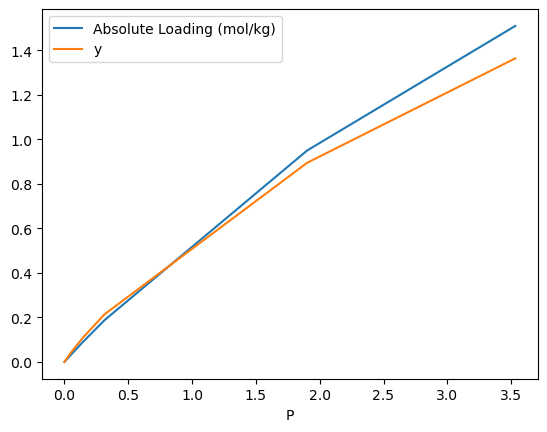

In [519]:
# Plot the P on the x-axis and Absolute Loading (mol/kg) and y on the y-axis
X.plot(x='P', y=['Absolute Loading (mol/kg)', 'y'], kind='line')

## Generate Computational Graph

Computational Graph Generated


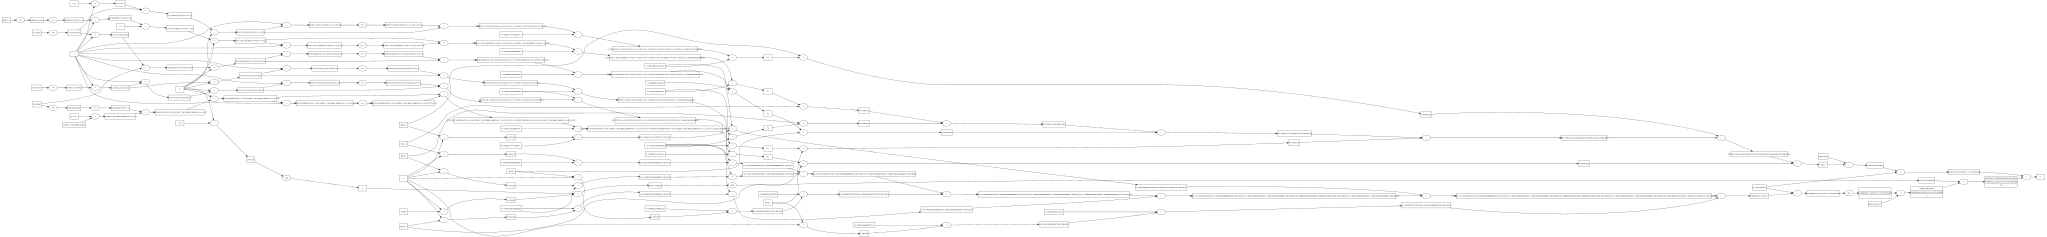

In [520]:
Value.reset()
# Pass in arbitrary values into our function because we are just trying to construct the causal graph
y = AI_DARWIN_EQUATION(*([0.1] * len(inspect.signature(AI_DARWIN_EQUATION).parameters)))
target_name = 'y'

computational_graph = draw_computational_graph(y, disable_data_field=True, disable_grad_field=True)
print("Computational Graph Generated")
computational_graph

## Build Causal Graph

[(['(1*ASA)', '(VolFrac**2)'], ['((VolFrac**2)*(1*ASA))'], [<function op_to_function.<locals>.mul at 0x169b19a80>]), (['(((((P*(1*(1*(void_frac**2))))+1)**-1)*(P*(1*(1*(void_frac**2)))))-0.13402139615626685)', '10.195811095300378'], ['f4'], [<function op_to_function.<locals>.mul at 0x31e5553a0>]), (['((P*(volume*(1*(VolFrac**2))))+1)'], ['(((P*(volume*(1*(VolFrac**2))))+1)**-1)'], [functools.partial(<function op_to_function.<locals>.pow at 0x31f5b6520>, exponent=-1)]), (['4.560658741657629', '(0.2099562104652133*(-beta3))'], ['(4.560658741657629*(0.2099562104652133*(-beta3)))'], [<function op_to_function.<locals>.mul at 0x31f5b72e0>]), (['beta6', 'f6'], ['(f6*beta6)'], [<function op_to_function.<locals>.mul at 0x31f5b74c0>]), (['(0.34510445568068854*(-beta1))', '6.311297195237251'], ['(6.311297195237251*(0.34510445568068854*(-beta1)))'], [<function op_to_function.<locals>.mul at 0x31a585ee0>]), (['((volume**2)**-1)', '(largest_included_sphere*NASA)'], ['(((volume**2)**-1)*(largest_incl

0it [00:00, ?it/s]


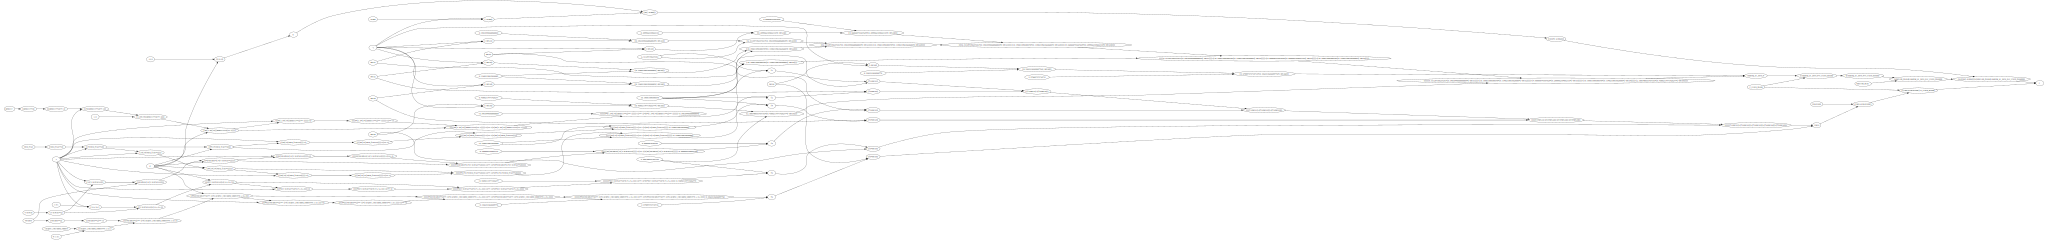

In [521]:
X.drop(labels=['y'], axis=1, inplace=True)

causal_graph = build_causal_graph(y, X, target_name, debug=False)
causal_graph.draw(rankdir='LR')

## Shapley Flow Analysis

### Holding Pressure Constant

In [522]:
nruns = 100 # number of monte carlo samples
sample_ind = 0
bg = ADSORBATE_DATA[BACKGROUND_ADSORBENT][TEMPERATURE].iloc[[PRESSURE_IDX]].drop(labels=['y'], axis=1)
fg = X.iloc[[PRESSURE_IDX]] # foreground samples to explain. Selecting row from X such that the pressure value is equal to the pressure value of bg
bg = bg[fg.columns] # ensure fg and bg have same column order. NOTE: this only works when there is 1 fg

In [523]:
print(BACKGROUND_ADSORBENT)
bg

MFS


temperature         P  Absolute Loading (mol/kg)   density  spg  \
29          373  0.144854                   0.065707  1.740399   44   

       volume  SiOSi_average  SiOSi_gmean  SiOSi_hmean   SiOSi_max  ...  \
29  19.109088     154.474733    154.32117   154.166676  164.377512  ...   

    |(loading_at_zero_P+y_train_mean)|  \
29                            0.013455   

    (epsilon_max*|(loading_at_zero_P+y_train_mean)|)  alpha  (-alpha)  -0.0  \
29                                          0.013455    2.0      -2.0  -0.0   

     (P-0.0)         d  (d*(-alpha))  e^((d*(-alpha)))  \
29  0.144854  0.144854     -0.289708          0.748482   

    (e^((d*(-alpha)))*(epsilon_max*|(loading_at_zero_P+y_train_mean)|))  
29                                           0.010071                    

[1 rows x 168 columns]

In [524]:
print(FOREGROUND_ADSORBENT)
fg

SIV


temperature         P  Absolute Loading (mol/kg)   density  spg  \
29          373  0.144854                   0.089389  1.632794   63   

       volume  SiOSi_average  SiOSi_gmean  SiOSi_hmean   SiOSi_max  ...  \
29  20.368423     149.233364    149.22465   149.215888  151.264571  ...   

    |(loading_at_zero_P+y_train_mean)|  \
29                            0.013455   

    (epsilon_max*|(loading_at_zero_P+y_train_mean)|)  alpha  (-alpha)  -0.0  \
29                                          0.013455    2.0      -2.0  -0.0   

     (P-0.0)         d  (d*(-alpha))  e^((d*(-alpha)))  \
29  0.144854  0.144854     -0.289708          0.748482   

    (e^((d*(-alpha)))*(epsilon_max*|(loading_at_zero_P+y_train_mean)|))  
29                                           0.010071                    

[1 rows x 168 columns]

In [536]:
cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph_with_constant_pressure = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 123.74it/s]


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg']' died with <Signals.SIGSEGV: 11>. [stderr: '']

### Simplified Shapley Flow with f Terms Only

#### Causal Link Functions

##### CH4

In [526]:
def get_causal_links_with_f_terms_only_CH4_323K():
    # Constants
    beta1 = -0.4054507842872319
    beta2 = -3.5824569383000946
    beta3 = 3.9932667095050705
    beta4 = 0.5222507180877926
    beta5 = 0.004795464592376811
    beta6 = -0.1129628499436825
    beta7 = 0.013835556053187287
    beta8 = -0.09608874134668977
    betas = [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.07469040214406462/0.233513075441677571 +
        -beta2*0.593439038924528/0.198559030356437852 + 
        -beta3*0.6258918477237851/0.199095730314402593 + 
        -beta4*0.026347531768028034/0.0330501158871211944 + 
        -beta5*0.451590663829706/0.49764971037256835 + 
        -beta6*0.04040880811128878/0.059921040583132836 + 
        -beta7*0.033471221601783376/0.112859511430337237 + 
        -beta8*0.3805783317820693/0.368377998195036368
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']]

    causal_links.add_causes_effects(
    ['largest_included_sphere', 'NAV', 'surf_area_m2cm3', 'P'],
    ['f1'],
    lambda largest_included_sphere, NAV, surf_area_m2cm3, P: 
        ((largest_included_sphere * np.exp(NAV) * np.exp(-surf_area_m2cm3)) * P / 
        (1 + (largest_included_sphere * np.exp(NAV) * np.exp(-surf_area_m2cm3)) * P) - 
        0.07469040214406462) / 0.23351307544167757
    )
    causal_links.add_causes_effects(
    ['VolFrac', 'AV', 'P'],
    ['f2'],
    lambda VolFrac, AV, P: 
        ((np.exp(VolFrac) / np.exp(-AV)) * P / 
        (1 + (np.exp(VolFrac) / np.exp(-AV)) * P) - 
        0.593439038924528) / 0.19855903035643785
    )
    causal_links.add_causes_effects(
    ['void_frac', 'P'],
    ['f3'],
    lambda void_frac, P: 
        ((np.exp(void_frac)) * P / 
        (1 + (np.exp(void_frac)) * P) - 
        0.6258918477237851) / 0.19909573031440259
    )
    causal_links.add_causes_effects(
    ['AV', 'VolFrac', 'void_frac', 'P'],
    ['f4'],
    lambda AV, VolFrac, void_frac, P: 
        ((AV / np.exp(VolFrac) * void_frac) * P / 
        (1 + (AV / np.exp(VolFrac) * void_frac) * P) - 
        0.026347531768028034) / 0.033050115887121194
    )
    causal_links.add_causes_effects(
    ['NASA', 'surf_area_m2cm3', 'spg', 'P'],
    ['f5'],
    lambda NASA, surf_area_m2cm3, spg, P: 
        ((np.exp(-NASA) * (surf_area_m2cm3**2) * spg) * P / 
        (1 + (np.exp(-NASA) * (surf_area_m2cm3**2) * spg) * P) - 
        0.451590663829706) / 0.4976497103725683
    )
    causal_links.add_causes_effects(
    ['surf_area_m2cm3', 'volume', 'P'],
    ['f6'],
    lambda surf_area_m2cm3, volume, P: 
        (((surf_area_m2cm3**2) * np.exp(-volume) * volume) * P / 
        (1 + ((surf_area_m2cm3**2) * np.exp(-volume) * volume) * P) - 
        0.04040880811128878) / 0.05992104058313283
    )
    causal_links.add_causes_effects(
    ['surf_area_m2g', 'pld', 'P'],
    ['f7'],
    lambda surf_area_m2g, pld, P: 
        ((1 / np.exp(surf_area_m2g) / pld) * P / 
        (1 + (1 / np.exp(surf_area_m2g) / pld) * P) - 
        0.033471221601783376) / 0.11285951143033723
    )
    causal_links.add_causes_effects(
    ['VolFrac', 'pld', 'P'],
    ['f8'],
    lambda VolFrac, pld, P: 
        ((VolFrac**2 / np.exp(-pld)) * P / 
        (1 + (VolFrac**2 / np.exp(-pld)) * P) - 
        0.3805783317820693) / 0.36837799819503636
    )
    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean - np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

In [527]:
def get_causal_links_with_f_terms_only_CH4_373K():
    beta1 = 0.1909906610367201
    beta2 = 0.11682964613884445
    beta3 = -0.09344427307559947
    beta4 = 0.20074867148999848
    beta5 = 0.11122063059032497
    beta6 = 0.5214533740342101
    beta7 = -0.3427553886500203
    beta8 = -0.21426185160030492
    betas = [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.5657765094736966/0.19576144586981531 +
        -beta2*0.4894973861635249/0.305116996449596172 + 
        -beta3*0.054277814589412984/0.097560942436884613 + 
        -beta4*0.07338101892284041/0.088032430338732454 + 
        -beta5*0.04457244307054062/0.149505513572373745 + 
        -beta6*0.13314539459770083/0.095672598214362036 + 
        -beta7*0.11368892880920235/0.10944603062166347 + 
        -beta8*0.0539764858809039/0.173903629938781068
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']]

    causal_links.add_causes_effects(
        ['P'],
        ['f1'],
        lambda P: 
            ((1) * P / 
            (1 + (1) * P) - 
            0.5657765094736966) / 0.1957614458698153
    )
    causal_links.add_causes_effects(
        ['largest_included_sphere_free', 'surf_area_m2cm3', 'P'],
        ['f2'],
        lambda largest_included_sphere_free, surf_area_m2cm3, P: 
            ((np.exp(-largest_included_sphere_free) * surf_area_m2cm3) * P / 
            (1 + (np.exp(-largest_included_sphere_free) * surf_area_m2cm3) * P) - 
            0.4894973861635249) / 0.30511699644959617
    )
    causal_links.add_causes_effects(
        ['NAV', 'spg', 'P'],
        ['f3'],
        lambda NAV, spg, P: 
            ((np.exp(NAV) / spg) * P / 
            (1 + (np.exp(NAV) / spg) * P) - 
            0.054277814589412984) / 0.09756094243688461
    )
    causal_links.add_causes_effects(
        ['density', 'VolFrac', 'P'],
        ['f4'],
        lambda density, VolFrac, P: 
            ((np.exp(density) * (VolFrac**2)) * P / 
            (1 + (np.exp(density) * (VolFrac**2)) * P) - 
            0.07338101892284041) / 0.08803243033873245
    )
    causal_links.add_causes_effects(
        ['largest_included_sphere_free', 'spg', 'largest_free_sphere', 'P'],
        ['f5'],
        lambda largest_included_sphere_free, spg, largest_free_sphere, P: 
            ((np.exp(largest_included_sphere_free) / (spg**2) / np.exp(largest_free_sphere)) * P / 
            (1 + (np.exp(largest_included_sphere_free) / (spg**2) / np.exp(largest_free_sphere)) * P) - 
            0.04457244307054062) / 0.14950551357237374
    )
    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f6'],
        lambda void_frac, P: 
            ((void_frac**2) * P / 
            (1 + (void_frac**2) * P) - 
            0.13314539459770083) / 0.09567259821436203
    )
    causal_links.add_causes_effects(
        ['VolFrac', 'void_frac', 'P'],
        ['f7'],
        lambda VolFrac, void_frac, P: 
            ((VolFrac**2 / (void_frac**2)) * P / 
            (1 + (VolFrac**2 / (void_frac**2)) * P) - 
            0.11368892880920235) / 0.1094460306216634
    )
    causal_links.add_causes_effects(
        ['surf_area_m2g', 'P'],
        ['f8'],
        lambda surf_area_m2g, P: 
            ((np.exp(-surf_area_m2g)) * P / 
            (1 + (np.exp(-surf_area_m2g)) * P) - 
            0.0539764858809039) / 0.17390362993878106
    )
    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean - np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

##### CO2

In [528]:
def get_causal_links_with_f_terms_only_CO2_323K():
    beta1 = 0.2408158535926262
    beta2 = -0.6051468741071055
    beta3 = 0.17771546567926963
    beta4 = -2.0804716603104425
    beta5 = -0.35101203615301246
    beta6 = 1.1201332339583743
    beta7 = 0.0023376143648303396
    beta8 = -0.12134179550190091
    beta9 = -1.215940666467515
    beta10 = 2.3657034591203896
    beta11 = -0.6619785317203183
    beta12 = 1.712890108697996
    betas = [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.5053560148639079/0.49606356479590331 + 
        -beta2*0.022023073277147264/0.074127264455499162 + 
        -beta3*0.636492475959887/0.47883190280181783 + 
        -beta4*0.15658870051279075/0.130147357334643284 + 
        -beta5*0.4486063640488222/0.27555650106218215 + 
        -beta6*0.769527662996705/0.19142549945155396 + 
        -beta7*0.018544154536591098/0.11340313997663167 + 
        -beta8*0.9474631921424108/0.111858997802339358 + 
        -beta9*0.2259632424704171/0.128197760414795259 + 
        -beta10*0.2983059470851118/0.1531433497568306710 + 
        -beta11*0.561041654561111/0.1990428899949868411 + 
        -beta12*0.10745167163360558/0.0993918568097935512
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']]

    causal_links.add_causes_effects(
        ['NASA', 'volume', 'P'],
        ['f1'],
        lambda NASA, volume, P: 
            ((NASA * volume) * P / 
            (1 + (NASA * volume) * P) - 
            0.5053560148639079) / 0.4960635647959033
    )

    causal_links.add_causes_effects(
        ['NAV', 'largest_free_sphere', 'largest_included_sphere', 'P'],
        ['f2'],
        lambda NAV, largest_free_sphere, largest_included_sphere, P: 
            ((NAV / np.exp(largest_free_sphere) * (largest_included_sphere**2)) * P / 
            (1 + (NAV / np.exp(largest_free_sphere) * (largest_included_sphere**2)) * P) - 
            0.022023073277147264) / 0.07412726445549916
    )

    causal_links.add_causes_effects(
        ['spg', 'NASA', 'AV', 'P'],
        ['f3'],
        lambda spg, NASA, AV, P: 
            ((np.exp(spg) * np.exp(-NASA) / np.exp(AV)) * P / 
            (1 + (np.exp(spg) * np.exp(-NASA) / np.exp(AV)) * P) - 
            0.636492475959887) / 0.4788319028018178
    )

    causal_links.add_causes_effects(
        ['density', 'VolFrac', 'P'],
        ['f4'],
        lambda density, VolFrac, P: 
            ((density * VolFrac) * P / 
            (1 + (density * VolFrac) * P) - 
            0.15658870051279075) / 0.13014735733464328
    )

    causal_links.add_causes_effects(
        ['lcd', 'largest_free_sphere', 'P'],
        ['f5'],
        lambda lcd, largest_free_sphere, P: 
            ((lcd**2 / np.exp(largest_free_sphere)) * P / 
            (1 + (lcd**2 / np.exp(largest_free_sphere)) * P) - 
            0.4486063640488222) / 0.2755565010621821
    )

    causal_links.add_causes_effects(
        ['volume', 'density', 'VolFrac', 'P'],
        ['f6'],
        lambda volume, density, VolFrac, P: 
            ((volume / np.exp(density) / np.exp(VolFrac)) * P / 
            (1 + (volume / np.exp(density) / np.exp(VolFrac)) * P) - 
            0.769527662996705) / 0.1914254994515539
    )

    causal_links.add_causes_effects(
        ['NASA', 'spg', 'P'],
        ['f7'],
        lambda NASA, spg, P: 
            ((NASA / np.exp(spg)) * P / 
            (1 + (NASA / np.exp(spg)) * P) - 
            0.018544154536591098) / 0.1134031399766316
    )

    causal_links.add_causes_effects(
        ['lcd', 'P'],
        ['f8'],
        lambda lcd, P: 
            ((lcd**2) * P / 
            (1 + (lcd**2) * P) - 
            0.9474631921424108) / 0.11185899780233935
    )

    causal_links.add_causes_effects(
        ['pld', 'volume', 'P'],
        ['f9'],
        lambda pld, volume, P: 
            ((pld / volume) * P / 
            (1 + (pld / volume) * P) - 
            0.2259632424704171) / 0.12819776041479525
    )

    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f10'],
        lambda void_frac, P: 
            ((void_frac) * P / 
            (1 + (void_frac) * P) - 
            0.2983059470851118) / 0.15314334975683067
    )

    causal_links.add_causes_effects(
        ['P'],
        ['f11'],
        lambda P: 
            ((1) * P / 
            (1 + (1) * P) - 
            0.561041654561111) / 0.19904288999498684
    )

    causal_links.add_causes_effects(
        ['VolFrac', 'P'],
        ['f12'],
        lambda VolFrac, P: 
            ((VolFrac) * P / 
            (1 + (VolFrac) * P) - 
            0.10745167163360558) / 0.09939185680979355
    )

    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean - np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

In [529]:
def get_causal_links_with_f_terms_only_CO2_373K():
    beta1 = -0.679081742692596
    beta2 = 0.20307777789750459
    beta3 = 0.4329129291782464
    beta4 = 0.3464949739458949
    beta5 = 0.17098884194225522
    beta6 = 2.2905076502184967
    beta7 = -0.22028767452266362
    beta8 = -1.2269155949581563
    beta9 = -0.8108018121501624
    beta10 = 0.05328000691618266
    beta11 = -0.19349635098380905
    beta12 = 0.284054306504558
    betas = [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.06471130620155797/0.083122152607038291 + 
        -beta2*0.047511004998993515/0.200784779541260262 + 
        -beta3*0.011389997203239096/0.0184915493862229773 + 
        -beta4*0.5646842961313753/0.300680505660976874 + 
        -beta5*0.5136090001227659/0.195901953568235785 + 
        -beta6*0.3000617637006874/0.153364435640597656 + 
        -beta7*0.49975562767787235/0.1913659966797387 + 
        -beta8*0.24088977178365023/0.181027711464625378 + 
        -beta9*0.16738596411370837/0.106554068911640219 + 
        -beta10*0.001524646748204257/0.01437310114160613410 + 
        -beta11*0.030270422267265115/0.103962722600690711 + 
        -beta12*0.029136294307661747/0.02771544659029635512
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']]

    causal_links.add_causes_effects(
        ['pld', 'P'],
        ['f1'],
        lambda pld, P: 
            ((np.exp(-pld)) * P / 
            (1 + (np.exp(-pld)) * P) - 
            0.06471130620155797) / 0.08312215260703829
    )

    causal_links.add_causes_effects(
        ['surf_area_m2g', 'NASA', 'P'],
        ['f2'],
        lambda surf_area_m2g, NASA, P: 
            ((np.exp(-surf_area_m2g) * NASA) * P / 
            (1 + (np.exp(-surf_area_m2g) * NASA) * P) - 
            0.047511004998993515) / 0.20078477954126026
    )

    causal_links.add_causes_effects(
        ['largest_included_sphere', 'NAV', 'P'],
        ['f3'],
        lambda largest_included_sphere, NAV, P: 
            ((np.exp(-largest_included_sphere) * np.exp(-NAV)) * P / 
            (1 + (np.exp(-largest_included_sphere) * np.exp(-NAV)) * P) - 
            0.011389997203239096) / 0.018491549386222977
    )

    causal_links.add_causes_effects(
        ['lcd', 'volume', 'P'],
        ['f4'],
        lambda lcd, volume, P: 
            ((np.exp(-lcd) * (volume**2)) * P / 
            (1 + (np.exp(-lcd) * (volume**2)) * P) - 
            0.5646842961313753) / 0.30068050566097687
    )

    causal_links.add_causes_effects(
        ['void_frac', 'density', 'P'],
        ['f5'],
        lambda void_frac, density, P: 
            ((np.exp(void_frac) / density) * P / 
            (1 + (np.exp(void_frac) / density) * P) - 
            0.5136090001227659) / 0.19590195356823578
    )

    causal_links.add_causes_effects(
        ['NAV', 'void_frac', 'P'],
        ['f6'],
        lambda NAV, void_frac, P: 
            ((np.exp(-NAV) * void_frac) * P / 
            (1 + (np.exp(-NAV) * void_frac) * P) - 
            0.3000617637006874) / 0.15336443564059765
    )

    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f7'],
        lambda void_frac, P: 
            ((np.exp(-void_frac)) * P / 
            (1 + (np.exp(-void_frac)) * P) - 
            0.49975562767787235) / 0.191365996679738
    )

    causal_links.add_causes_effects(
        ['density', 'VolFrac', 'P'],
        ['f8'],
        lambda density, VolFrac, P: 
            (((density**2) * VolFrac * np.exp(VolFrac)) * P / 
            (1 + ((density**2) * VolFrac * np.exp(VolFrac)) * P) - 
            0.24088977178365023) / 0.18102771146462537
    )

    causal_links.add_causes_effects(
        ['largest_free_sphere', 'largest_included_sphere_free', 'P'],
        ['f9'],
        lambda largest_free_sphere, largest_included_sphere_free, P: 
            ((largest_free_sphere / (largest_included_sphere_free**2)) * P / 
            (1 + (largest_free_sphere / (largest_included_sphere_free**2)) * P) - 
            0.16738596411370837) / 0.10655406891164021
    )

    causal_links.add_causes_effects(
        ['NASA', 'P'],
        ['f10'],
        lambda NASA, P: 
            (((NASA**2) / np.exp(NASA)) * P / 
            (1 + ((NASA**2) / np.exp(NASA)) * P) - 
            0.001524646748204257) / 0.014373101141606134
    )

    causal_links.add_causes_effects(
        ['surf_area_m2g', 'NAV', 'P'],
        ['f11'],
        lambda surf_area_m2g, NAV, P: 
            ((surf_area_m2g * (NAV**2)) * P / 
            (1 + (surf_area_m2g * (NAV**2)) * P) - 
            0.030270422267265115) / 0.1039627226006907
    )

    causal_links.add_causes_effects(
        ['VolFrac', 'largest_free_sphere', 'P'],
        ['f12'],
        lambda VolFrac, largest_free_sphere, P: 
            ((VolFrac / largest_free_sphere) * P / 
            (1 + (VolFrac / largest_free_sphere) * P) - 
            0.029136294307661747) / 0.027715446590296355
    )

    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean - np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

##### N2

In [530]:
def get_causal_links_with_f_terms_only_N2_323K():
    beta1 = -0.06012649624795871
    beta2 = 0.29171999178744773
    beta3 = -0.001505369599999802
    beta4 = 0.030830007929509663
    beta5 = -0.3257118942142511
    beta6 = 0.5292953747226462
    betas = [beta1, beta2, beta3, beta4, beta5, beta6]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.024842285545539616/0.0293150869871573431 + 
        -beta2*0.4555766667320463/0.229069661570638882 + 
        -beta3*0.7755018982379761/0.24098266572717433 + 
        -beta4*0.48063444011241646/0.47789630752610824 + 
        -beta5*0.3032790874679304/0.301721304100847745 + 
        -beta6*0.13327729792619633/0.097269266955138276  
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']]

    causal_links.add_causes_effects(
        ['pld', 'void_frac', 'volume', 'P'],
        ['f1'],
        lambda pld, void_frac, volume, P: 
            ((pld**2 * void_frac / volume**2) * P / 
            (1 + (pld**2 * void_frac / volume**2) * P) - 
            0.024842285545539616) / 0.029315086987157343
    )

    causal_links.add_causes_effects(
        ['void_frac', 'lcd', 'density', 'P'],
        ['f2'],
        lambda void_frac, lcd, density, P: 
            ((void_frac * lcd / density**2) * P / 
            (1 + (void_frac * lcd / density**2) * P) - 
            0.4555766667320463) / 0.22906966157063888
    )

    causal_links.add_causes_effects(
        ['void_frac', 'spg', 'P'],
        ['f3'],
        lambda void_frac, spg, P: 
            ((void_frac**2 * spg) * P / 
            (1 + (void_frac**2 * spg) * P) - 
            0.7755018982379761) / 0.2409826657271743
    )

    causal_links.add_causes_effects(
        ['NASA', 'density', 'P'],
        ['f4'],
        lambda NASA, density, P: 
            ((NASA / density**2) * P / 
            (1 + (NASA / density**2) * P) - 
            0.48063444011241646) / 0.4778963075261082
    )

    causal_links.add_causes_effects(
        ['largest_included_sphere_free', 'lcd', 'VolFrac', 'P'],
        ['f5'],
        lambda largest_included_sphere_free, lcd, VolFrac, P: 
            ((largest_included_sphere_free * lcd * VolFrac**2) * P / 
            (1 + (largest_included_sphere_free * lcd * VolFrac**2) * P) - 
            0.3032790874679304) / 0.30172130410084774
    )

    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f6'],
        lambda void_frac, P: 
            ((void_frac**2) * P / 
            (1 + (void_frac**2) * P) - 
            0.13327729792619633) / 0.09726926695513827
    )

    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean - np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

In [531]:
def get_causal_links_with_f_terms_only_N2_373K():
    beta1 = 0.07337148018041849
    beta2 = 1430198749526.224
    beta3 = -0.2230577953955047
    beta4 = -1430198749525.754
    beta5 = 0.0414632001791709
    beta6 = 0.043098439630175324
    betas = [beta1, beta2, beta3, beta4, beta5, beta6]
    intercept = 0.0
    loading_at_zero_P = (
        -beta1*0.34510445568068854/0.158446032418603061 + 
        -beta2*0.13402139615626685/0.098079494672173422 + 
        -beta3*0.2099562104652133/0.21926657017019813 + 
        -beta4*0.13402139615626685/0.098079494672173424 + 
        -beta5*0.43892114771426277/0.433060152769236765 + 
        -beta6*0.3362313626509776/0.3876123176749836
    )
    epsilon_max = 1.0
    y_train_mean = np.mean(y_train)
    alpha = 2.0

    causal_links = CausalLinks()
    target_name = 'y'
    X_with_only_f_terms = X[list(inspect.signature(AI_DARWIN_EQUATION).parameters.keys()) + ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']]

    causal_links.add_causes_effects(
        ['density', 'P'],
        ['f1'],
        lambda density, P: 
            ((1 / density**2) * P / 
            (1 + (1 / density**2) * P) - 
            0.34510445568068854) / 0.15844603241860306
    )

    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f2'],
        lambda void_frac, P: 
            ((void_frac**2) * P / 
            (1 + (void_frac**2) * P) - 
            0.13402139615626685) / 0.09807949467217342
    )

    causal_links.add_causes_effects(
        ['VolFrac', 'volume', 'P'],
        ['f3'],
        lambda VolFrac, volume, P: 
            ((VolFrac**2 * volume) * P / 
            (1 + (VolFrac**2 * volume) * P) - 
            0.2099562104652133) / 0.2192665701701981
    )

    causal_links.add_causes_effects(
        ['void_frac', 'P'],
        ['f4'],
        lambda void_frac, P: 
            ((void_frac**2) * P / 
            (1 + (void_frac**2) * P) - 
            0.13402139615626685) / 0.09807949467217342
    )

    causal_links.add_causes_effects(
        ['ASA', 'VolFrac', 'P'],
        ['f5'],
        lambda ASA, VolFrac, P: 
            ((ASA * VolFrac**2) * P / 
            (1 + (ASA * VolFrac**2) * P) - 
            0.43892114771426277) / 0.43306015276923676
    )

    causal_links.add_causes_effects(
        ['NASA', 'largest_included_sphere', 'volume', 'P'],
        ['f6'],
        lambda NASA, largest_included_sphere, volume, P: 
            ((NASA * largest_included_sphere / volume**2) * P / 
            (1 + (NASA * largest_included_sphere / volume**2) * P) - 
            0.3362313626509776) / 0.387612317674983
    )

    causal_links.add_causes_effects(
        ['P', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'],
        [target_name],
        lambda P, *features: sum([beta * f for (beta, f) in zip(betas, features)]) + intercept + y_train_mean + np.abs(loading_at_zero_P + y_train_mean) * epsilon_max * np.exp(-alpha * np.abs(P - 0.0)),
    )
    
    return causal_links, X_with_only_f_terms

##### Function Map

In [532]:
function_map_causal_links_with_f_terms_only = {
    'CH4': {
        323: get_causal_links_with_f_terms_only_CH4_323K,
        373: get_causal_links_with_f_terms_only_CH4_373K,
    },
    'CO2': {
        323: get_causal_links_with_f_terms_only_CO2_323K,
        373: get_causal_links_with_f_terms_only_CO2_373K,
    },
    'N2': {
        323: get_causal_links_with_f_terms_only_N2_323K,
        373: get_causal_links_with_f_terms_only_N2_373K,
    }
}
GET_CAUSAL_LINKS_WITH_F_TERMS_ONLY = function_map_causal_links_with_f_terms_only[ADSORBATE][TEMPERATURE]

#### Generate Simplified Shapley Flow Graph

0it [00:00, ?it/s]


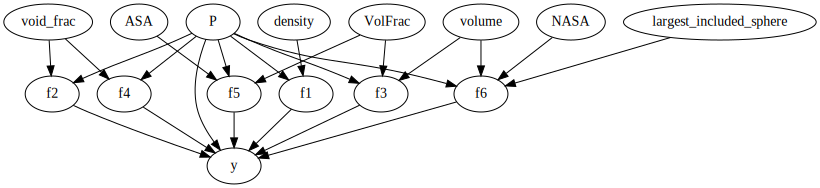

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 620.49it/s]


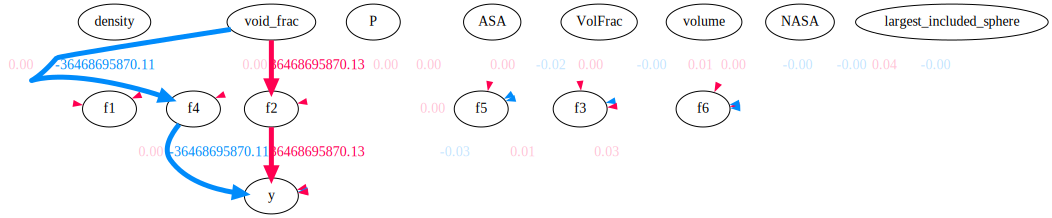

In [533]:
causal_links, X_with_only_f_terms = GET_CAUSAL_LINKS_WITH_F_TERMS_ONLY()
causal_graph_simplified = build_feature_graph(X_with_only_f_terms, causal_links, target_name=target_name)
causal_graph_simplified.draw(rankdir='TB')

nruns = 100 # number of monte carlo samples
sample_ind = 0
bg = ADSORBATE_DATA[BACKGROUND_ADSORBENT][TEMPERATURE].iloc[[PRESSURE_IDX]].drop(labels=['y'], axis=1)
fg = X.iloc[[PRESSURE_IDX]] # foreground samples to explain. Selecting row from X such that the pressure value is equal to the pressure value of bg
bg = bg[fg.columns] # ensure fg and bg have same column order. NOTE: this only works when there is 1 fg

cf_flow = GraphExplainer(causal_graph_simplified, bg, nruns=nruns).shap_values(fg, rankdir='TB')
cf_flow.fold_noise = True
shapflow_graph_simplified = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

## Save Results

In [534]:
dir_name = 'zeolite'
save_dir = f'results/{dir_name}/{ADSORBATE}/{TEMPERATURE}'
os.makedirs(save_dir, exist_ok=True)

computational_graph.render(os.path.join(save_dir, 'computational_graph'), format='svg')
causal_graph.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph.svg'),
    format='svg',
    prog='dot'
)
shapflow_graph_with_constant_pressure.draw(
    path=os.path.join(save_dir, f'shapflow_graph_{BACKGROUND_ADSORBENT}_to_{FOREGROUND_ADSORBENT}.svg'),
    format='svg',
    prog='dot'
)
causal_graph_simplified.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph_simplified.svg'),
    format='svg',
    prog='dot'
)
shapflow_graph_simplified.draw(
    path=os.path.join(save_dir, f'shapflow_graph_simplified_{BACKGROUND_ADSORBENT}_to_{FOREGROUND_ADSORBENT}.svg'),
    format='svg',
    prog='dot'
)
print("All graphs have been saved to:", save_dir)

OSError: 